# Transfer Learning with MobileNetV2

1) Binary classification: Alpaca/not-alpaca

In [1]:
# Import Packages
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "datasets/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


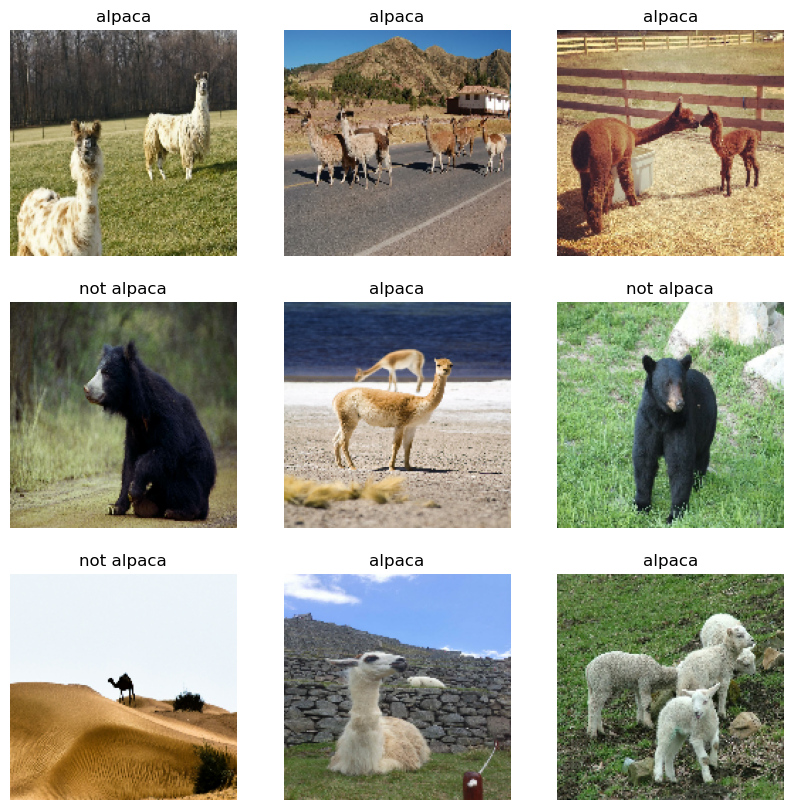

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

There are some mislabeled images

In [4]:
# Using prefetch() prevents a memory bottleneck that can occur when reading from disk
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
# Data Augmentation
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    
    # other data augmentation features can be used such as changing the zoom, height and weight of the images.
    # Only rotation and flipping will be introduced
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tfl.experimental.preprocessing.RandomFlip('horizontal'))
    data_augmentation.add(tfl.experimental.preprocessing.RandomRotation(0.2))

    return data_augmentation


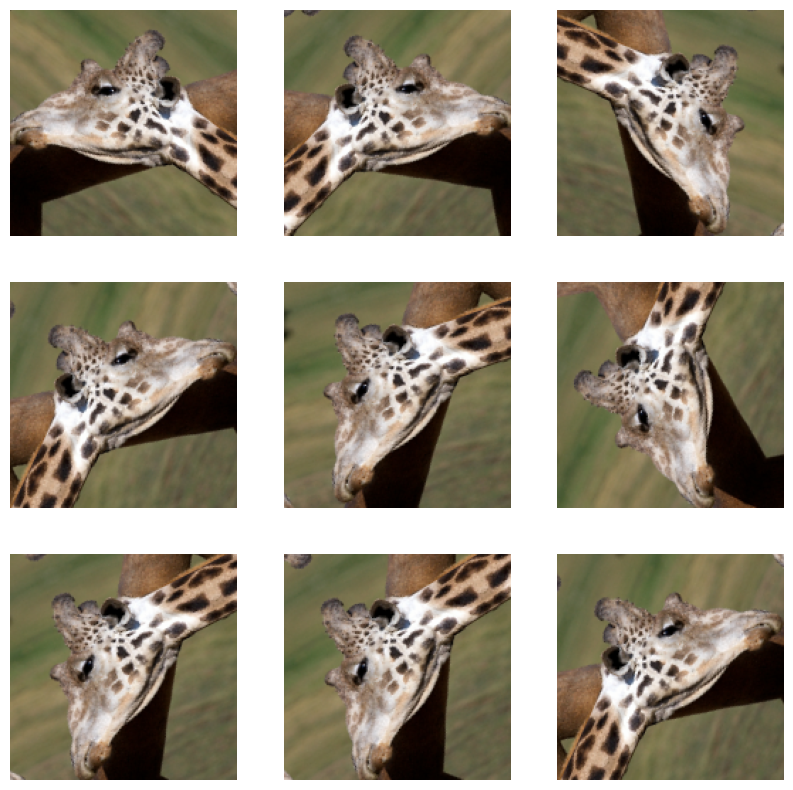

In [6]:
data_augmentation = data_augmenter()

# checking an example from 1 image to see the modifications/augmentations applied to a single image
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [7]:
# Will be using the MobileNet model which was trained on normalized values  [-1,1].  
# use "tf.keras.applications.mobilenet_v2.preprocess_input" to do apply the same normalization as in the original model.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications.
* 155 layers deep
* very efficient for object detection and image segmentation tasks, as well as classification
* Architecture features: 
    Depthwise separable convolutions
    Thin input and output bottlenecks between layers
    Shortcut connections between bottleneck layers

<img src="Images/model_schematics.png" style="width:650px;height:450px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  :  <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation."><b>MobileNetV2 Architecture</b></a>.</center></caption>
    


In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet') # load the pretrained weights from ImageNet

In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [10]:
# The last 2 layers are responsible for the classification
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [11]:
# choose the first batch from the tensorflow dataset to use the image
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [12]:
# 32 is the batch size and 1000 refers to the 1000 classes the model was pretrained on

In [13]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0])>

In [14]:
# Decoding the classification
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n02489166', 'proboscis_monkey', 0.10329921),
  ('n02102177', 'Welsh_springer_spaniel', 0.078836575)],
 [('n02125311', 'cougar', 0.16546653), ('n02389026', 'sorrel', 0.10764315)],
 [('n02437312', 'Arabian_camel', 0.29232812),
  ('n02437616', 'llama', 0.2771365)],
 [('n03944341', 'pinwheel', 0.3115491), ('n03047690', 'clog', 0.052500285)],
 [('n02454379', 'armadillo', 0.7310724), ('n01990800', 'isopod', 0.03871982)],
 [('n02437312', 'Arabian_camel', 0.2566362),
  ('n02422106', 'hartebeest', 0.121226996)],
 [('n02437616', 'llama', 0.6612558),
  ('n02090721', 'Irish_wolfhound', 0.23782855)],
 [('n02133161', 'American_black_bear', 0.8273558),
  ('n02134418', 'sloth_bear', 0.029259544)],
 [('n01518878', 'ostrich', 0.9267559),
  ('n02002724', 'black_stork', 0.0017766276)],
 [('n01518878', 'ostrich', 0.9495457), ('n02018795', 'bustard', 0.0028661739)],
 [('n02437616', 'llama', 0.8699833), ('n02412080', 'ram', 0.076757126)],
 [('n02415577', 'bighorn', 0.24294455), ('n02412080', 'ram', 0.160

MobileNet was pretrained over ImageNet doesn't have the correct labels for alpacas/non-alpcas
Using the full model this is what comes out

Delete the top layer (classification) and create a new one for the task at hand


In [15]:
## Adapting the model

# Layer Freezing with the Functional API

# Delete the top layer (the classification layer)

# Add a new classifier layer

# Train only one layer by freezing the rest of the network
# One single neuron is enough to solve a binary classification problem.


In [16]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,) # adding the 3 channels
    
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # will remove the last layer responsible for the classification 
                                                                      # global_average_pooling2d and predictions
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=(160, 160, 3)) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batchnorm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # Prediction Layer
    outputs = tfl.Dense(1)(x)
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [17]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [18]:
lr_base = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_base),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 8s 318ms/step - loss: 0.8827 - accuracy: 0.4656 - val_loss: 0.5588 - val_accuracy: 0.7538
Epoch 2/5
9/9 [==============================] - 2s 183ms/step - loss: 0.6500 - accuracy: 0.6412 - val_loss: 0.4613 - val_accuracy: 0.7692
Epoch 3/5
9/9 [==============================] - 6s 715ms/step - loss: 0.5518 - accuracy: 0.6985 - val_loss: 0.3907 - val_accuracy: 0.8308
Epoch 4/5
9/9 [==============================] - 2s 183ms/step - loss: 0.4678 - accuracy: 0.7519 - val_loss: 0.3589 - val_accuracy: 0.8154
Epoch 5/5
9/9 [==============================] - 2s 181ms/step - loss: 0.4526 - accuracy: 0.7519 - val_loss: 0.3152 - val_accuracy: 0.8769


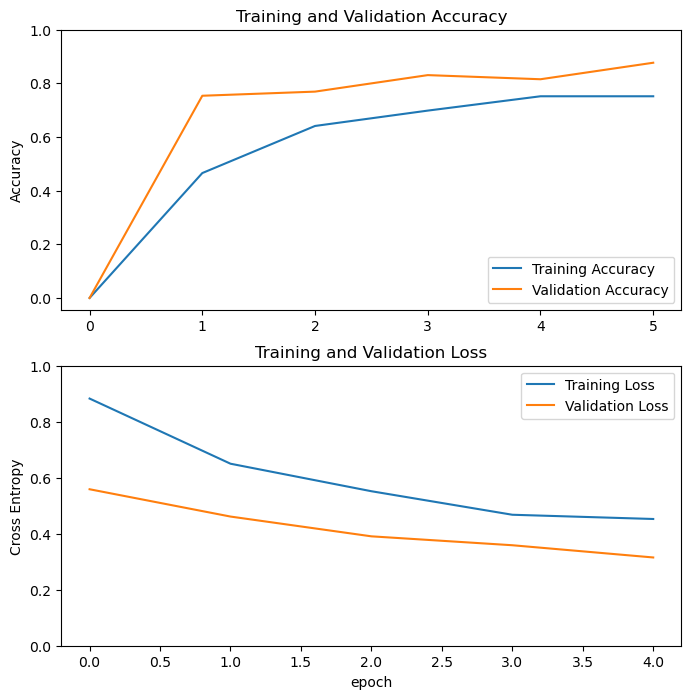

In [20]:
#Plot the training and validation accuracy and loss:

acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
class_names

['alpaca', 'not alpaca']

In [22]:
# Fine-tuning the model
# unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.
# the later layers contain the fine details that are more specific to the problem in hand
# Where the final layers actually begin is arbitrary (a parameter that can be adjusted)

base_model = model2.layers[4]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function with from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define Adam optimizer with a learning rate of 0.1 * lr_base
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_base*0.1)
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [23]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 14s 915ms/step - loss: 0.6599 - accuracy: 0.6832 - val_loss: 0.4238 - val_accuracy: 0.8462
Epoch 6/10
9/9 [==============================] - 2s 228ms/step - loss: 0.4428 - accuracy: 0.7405 - val_loss: 0.2140 - val_accuracy: 0.9077
Epoch 7/10
9/9 [==============================] - 6s 745ms/step - loss: 0.3144 - accuracy: 0.8702 - val_loss: 0.2096 - val_accuracy: 0.8462
Epoch 8/10
9/9 [==============================] - 2s 216ms/step - loss: 0.2507 - accuracy: 0.8664 - val_loss: 0.1221 - val_accuracy: 0.9692
Epoch 9/10
9/9 [==============================] - 7s 590ms/step - loss: 0.1994 - accuracy: 0.9122 - val_loss: 0.1186 - val_accuracy: 0.9538
Epoch 10/10
9/9 [==============================] - 7s 768ms/step - loss: 0.1793 - accuracy: 0.9466 - val_loss: 0.1257 - val_accuracy: 0.9231


In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

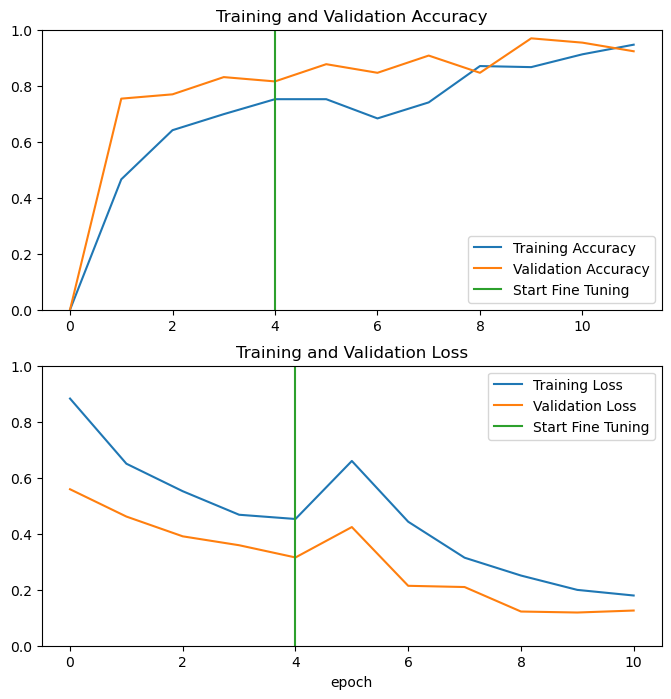

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [115]:
model2.evaluate(validation_dataset)

3/3 [==============================] - 0s 68ms/step - loss: 0.1727 - accuracy: 0.9385


[0.17272193729877472, 0.9384615421295166]

In [32]:
test_dataset = image_dataset_from_directory('datasets/test/',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0,
                                             seed=42)

Found 9 files belonging to 2 classes.


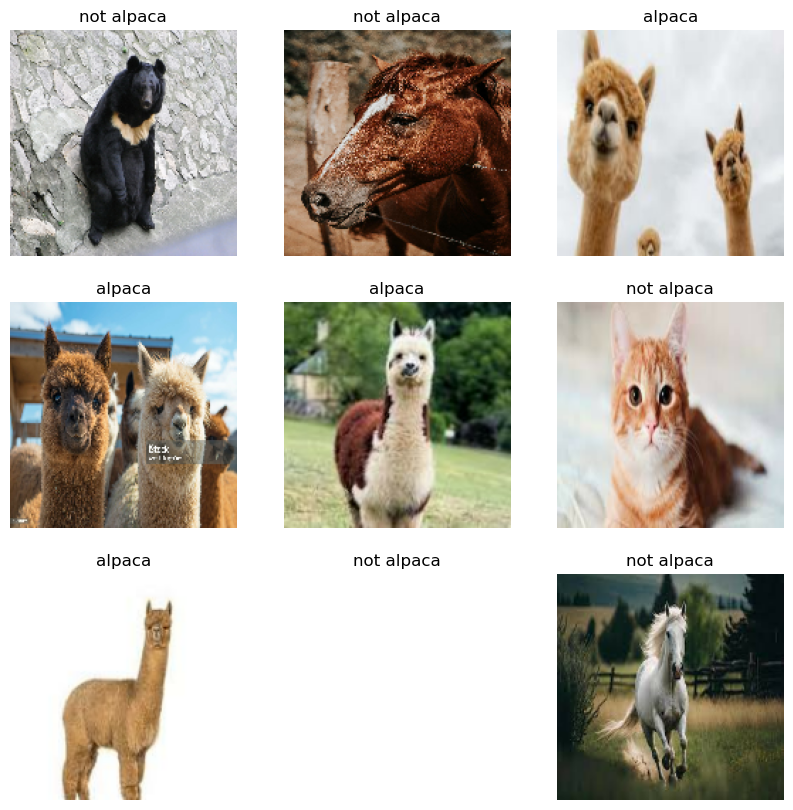

In [38]:
class_names = test_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

1/1 [==============================] - 0s 31ms/step


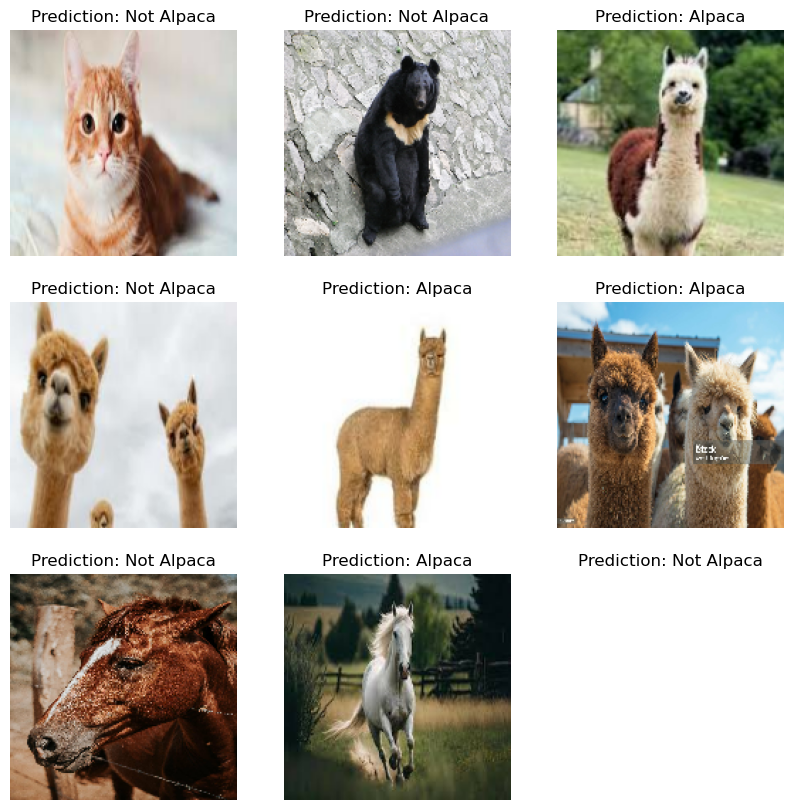

In [54]:



plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        result_1 = model2.predict(tf.expand_dims(images[i], axis=0))
        result =  "Not Alpaca" if model2.predict(tf.expand_dims(images[i], axis=0)) > 0 else "Alpaca"
        plt.title('Prediction: ' + result)
        plt.axis("off")


In [ ]:
# still made a few mistakes